In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
%matplotlib inline  

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
import os
img_dir = 'small_correct-images/'
import matplotlib.image as mpimg

In [5]:
thesis_embeddings = pd.read_csv('thesis_face_embeddings/guess_who_embeddings_pandas.csv')

emb = thesis_embeddings.encodings

emb = (emb
 .str.replace('\n','')
 .str.replace('\r','')
 .str.replace('[','')
 .str.replace(']','')
 .str.split())

emb_lists = emb.tolist()

thesis_emb = np.asarray(emb_lists)

thesis_emb = thesis_emb.astype(np.float)

In [6]:
X_test = thesis_emb 

In [7]:
df = pd.read_csv('csv/thesis_faces_ground_truth.csv')

In [8]:
df.columns

Index(['Unnamed: 0', 'faceID', 'face_perceived_physical-description',
       'face_perceived_ethnicity', 'face_perceived_ethnicity-details',
       'face_perceived_eye', 'face_perceived_hair',
       'face_perceived_photo-gender', 'uniqueID', 'face_gender_mode',
       'face_gender_consensus', 'glasses_mentioned', 'glasses',
       'eye_consensus_prop', 'eye_perceived', 'nr_eye_col',
       'hair_consensus_prop', 'hair_perceived', 'nr_hair_col'],
      dtype='object')

In [9]:
hair_df = df[['faceID', 'hair_perceived', 'hair_consensus_prop', 'nr_hair_col']].sort_values('faceID').reset_index().drop(columns='index')


In [10]:
hair_df.hair_perceived.value_counts()

brown     94
black     65
blonde    28
tie        6
Name: hair_perceived, dtype: int64

In [11]:
y_test = hair_df.hair_perceived.values

In [12]:
hair_keras_model = pickle.load(open('celeba/hair_keras_model.sav', 'rb'))

C:\Users\Paradigit\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
y_prob = hair_keras_model.predict(X_test)
y_pred = (y_prob > 0.5)

In [14]:
y_prob[0]

array([0.01128481, 0.02456522, 0.61601853, 0.34813148], dtype=float32)

In [15]:


y = pd.DataFrame(y_prob)

In [16]:
y = y.rename(columns={ y.columns[0]: "bald" }).rename(columns={ y.columns[1]: "black" }).rename(columns={ y.columns[2]: "brown" }).rename(columns={ y.columns[3]: "blond" })

In [17]:
hair_df = pd.concat([hair_df, y], axis=1)


In [17]:
hair_df.head()

,faceID,hair_perceived,hair_consensus_prop,nr_hair_col,bald,black,brown,blond
0,IMG_0003,blonde,0.833333,2,0.011285,0.024565,0.616019,0.348131
1,IMG_0018,blonde,0.916667,2,0.003097,0.007338,0.611844,0.377721
2,IMG_0033,brown,0.916667,2,0.001384,0.809157,0.004715,0.184744
3,IMG_0048,brown,1.000000,1,0.000016,0.573698,0.011095,0.415191
4,IMG_0063,brown,0.923077,2,0.000024,0.191906,0.028695,0.779376


In [18]:
def prediction(row):
    #if nothing scores higher than 0.5 return other
    if row.bald < 0.5 and row.black < 0.5 and row.brown < 0.5 and row.blond < 0.5:
        return 'other'
    
    #else if bald is higher than other values return bald
    elif row.bald > row.black and row.bald > row.brown and row.bald > row.blond:
        return 'bald'
    
    #same for black
    elif row.black > row.bald and row.black > row.brown and row.black > row.blond:
        return 'black'
    
    #same for brown
    elif row.brown > row.bald and row.brown > row.black and row.brown > row.blond:
        return 'brown'
    
    #and else return blonde
    else:
        return 'blonde'
    
hair_df['prediction'] = hair_df.apply(prediction, axis=1)


In [19]:
hair_df.head()

,faceID,hair_perceived,hair_consensus_prop,nr_hair_col,bald,black,brown,blond,prediction
0,IMG_0003,blonde,0.833333,2,0.011285,0.024565,0.616019,0.348131,brown
1,IMG_0018,blonde,0.916667,2,0.003097,0.007338,0.611844,0.377721,brown
2,IMG_0033,brown,0.916667,2,0.001384,0.809157,0.004715,0.184744,black
3,IMG_0048,brown,1.000000,1,0.000016,0.573698,0.011095,0.415191,black
4,IMG_0063,brown,0.923077,2,0.000024,0.191906,0.028695,0.779376,blonde


In [19]:
hairnotie = hair_df[hair_df.hair_perceived != 'tie']

In [20]:
hairnotie.prediction.value_counts()

black     91
blonde    73
brown     15
bald       4
other      4
Name: prediction, dtype: int64

In [23]:
hairnotie.hair_perceived.value_counts()

brown     94
black     65
blonde    28
Name: hair_perceived, dtype: int64

In [21]:
hair_df[hair_df.prediction == 'bald']

,faceID,hair_perceived,hair_consensus_prop,nr_hair_col,bald,black,brown,blond,prediction
9,IMG_0138,black,0.909091,2,0.500184,0.499417,0.000055,0.000345,bald
61,IMG_7653,brown,0.550000,2,0.924737,0.039208,0.003211,0.032844,bald
175,IMG_9725,black,0.833333,2,0.707782,0.292017,0.000027,0.000174,bald
185,IMG_9876,blonde,0.545455,4,0.700435,0.001485,0.073753,0.224327,bald


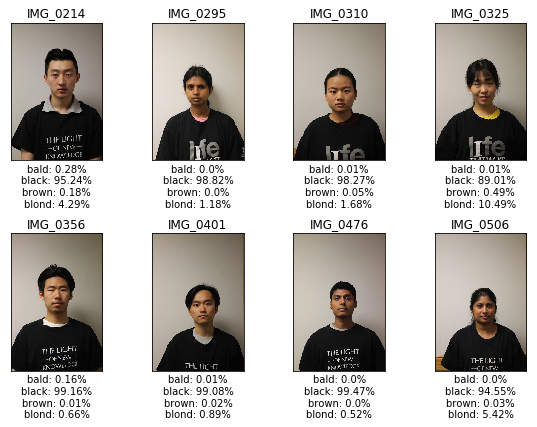

In [26]:
black = hairnotie[hairnotie.hair_perceived == 'black']

bl_bl = black[black.prediction == 'black']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

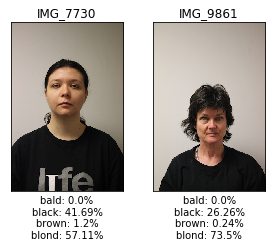

In [28]:
black = hairnotie[hairnotie.hair_perceived == 'black']

bl_blo = black[black.prediction == 'blonde']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_blo.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_blo.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_blo.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_blo.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_blo.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

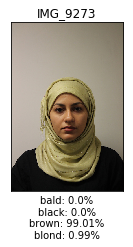

In [29]:
black = hairnotie[hairnotie.hair_perceived == 'black']

bl_blo = black[black.prediction == 'brown']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_blo.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_blo.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_blo.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_blo.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_blo.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

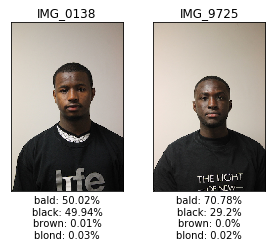

In [30]:
black = hairnotie[hairnotie.hair_perceived == 'black']

bl_blo = black[black.prediction == 'bald']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_blo.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_blo.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_blo.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_blo.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_blo.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

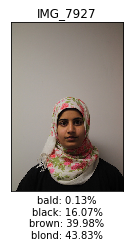

In [31]:
black = hairnotie[hairnotie.hair_perceived == 'black']

bl_blo = black[black.prediction == 'other']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_blo.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_blo.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_blo.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_blo.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_blo.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

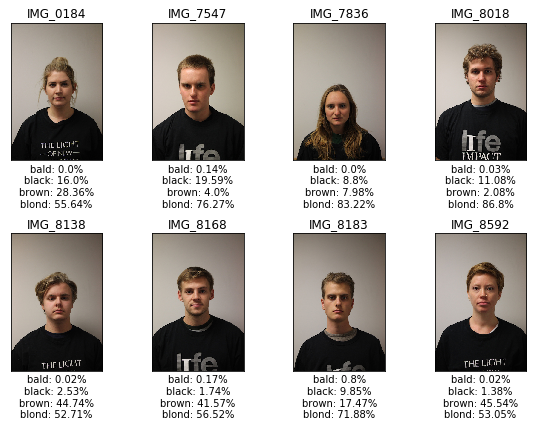

In [36]:
blond = hairnotie[hairnotie.hair_perceived == 'blonde']

bl_bl = blond[blond.prediction == 'blonde']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

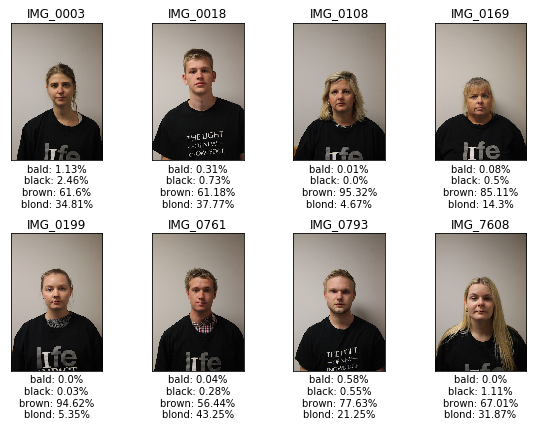

In [38]:
blond = hairnotie[hairnotie.hair_perceived == 'blonde']

bl_bl = blond[blond.prediction == 'brown']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

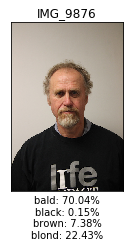

In [39]:
blond = hairnotie[hairnotie.hair_perceived == 'blonde']

bl_bl = blond[blond.prediction == 'bald']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

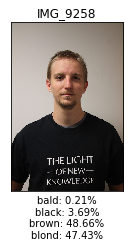

In [40]:
blond = hairnotie[hairnotie.hair_perceived == 'blonde']

bl_bl = blond[blond.prediction == 'other']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

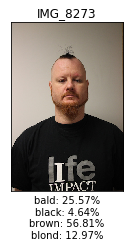

In [41]:
brown = hairnotie[hairnotie.hair_perceived == 'brown']

bl_bl = brown[brown.prediction == 'brown']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

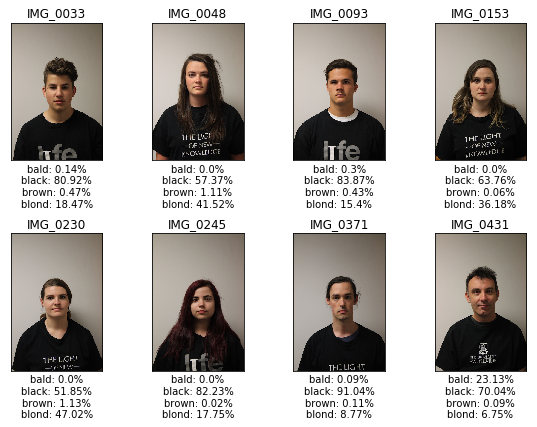

In [42]:
brown = hairnotie[hairnotie.hair_perceived == 'brown']

bl_bl = brown[brown.prediction == 'black']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

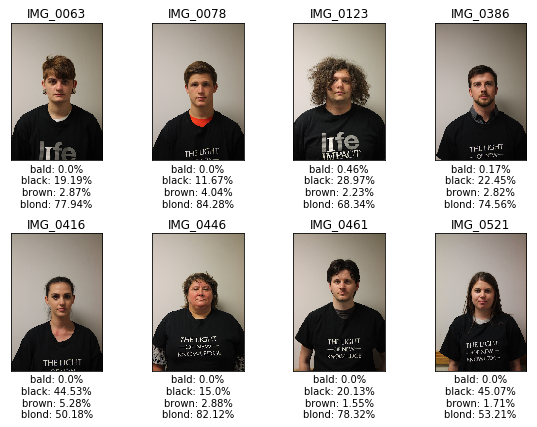

In [43]:
brown = hairnotie[hairnotie.hair_perceived == 'brown']

bl_bl = brown[brown.prediction == 'blonde']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values[:8]):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

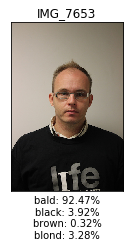

In [44]:
brown = hairnotie[hairnotie.hair_perceived == 'brown']

bl_bl = brown[brown.prediction == 'bald']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

In [ ]:
brown = hairnotie[hairnotie.hair_perceived == 'brown']

bl_bl = brown[brown.prediction == 'bald']

plt.figure(figsize=(8,6))
for i, face in enumerate(bl_bl.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(asian_white.prediction.values[i] + ': ' + str(round(asian_white.white.values[i] * 100, 2)) + "%")
    (plt.xlabel('bald' + ': ' + str(round(bl_bl.bald.values[i] * 100, 2)) + "%\n"
               'black' + ': ' + str(round(bl_bl.black.values[i] * 100, 2)) + "%\n"
               'brown' + ': ' + str(round(bl_bl.brown.values[i] * 100, 2)) + "%\n"
               'blond' + ': ' + str(round(bl_bl.blond.values[i] * 100, 2)) + "%"))

plt.tight_layout()
plt.show()

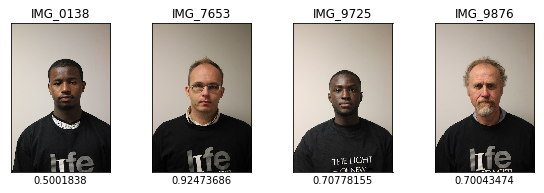

In [22]:
#bald
bald = hair_df[hair_df.prediction == 'bald']
plt.figure(figsize=(8,5))
for i, face in enumerate(bald.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    plt.xlabel(bald.bald.values[i])

plt.tight_layout()
plt.show()

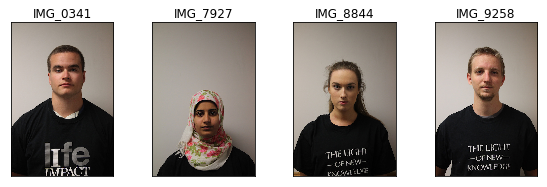

In [42]:
#other
other = hair_df[hair_df.prediction == 'other']
plt.figure(figsize=(8,5))
for i, face in enumerate(other.faceID.values):
    
    plt.subplot(2,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel(other.other.values[i])

plt.tight_layout()
plt.show()

In [27]:
hair_df[hair_df.prediction == 'other']

,faceID,hair_perceived,hair_consensus_prop,nr_hair_col,bald,black,brown,blond,prediction
20,IMG_0341,brown,0.818182,3,0.099039,0.406551,0.117765,0.376645,other
79,IMG_7927,black,0.714286,2,0.001292,0.160695,0.399752,0.438262,other
119,IMG_8844,brown,0.818182,2,0.000053,0.115300,0.390196,0.494451,other
144,IMG_9258,blonde,0.823529,3,0.002098,0.036946,0.486611,0.474345,other


In [25]:
y_test = hairnotie.hair_perceived.values
y_pred = hairnotie.prediction.values

In [26]:

print("{:.3}".format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test,y_pred))

print(confusion_matrix(y_test,y_pred))

0.39
             precision    recall  f1-score   support

       bald       0.00      0.00      0.00         0
      black       0.65      0.91      0.76        65
     blonde       0.18      0.46      0.26        28
      brown       0.07      0.01      0.02        94
      other       0.00      0.00      0.00         0

avg / total       0.29      0.39      0.31       187

[[ 0  0  0  0  0]
 [ 2 59  2  1  1]
 [ 1  0 13 13  1]
 [ 1 32 58  1  2]
 [ 0  0  0  0  0]]


C:\Users\Paradigit\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


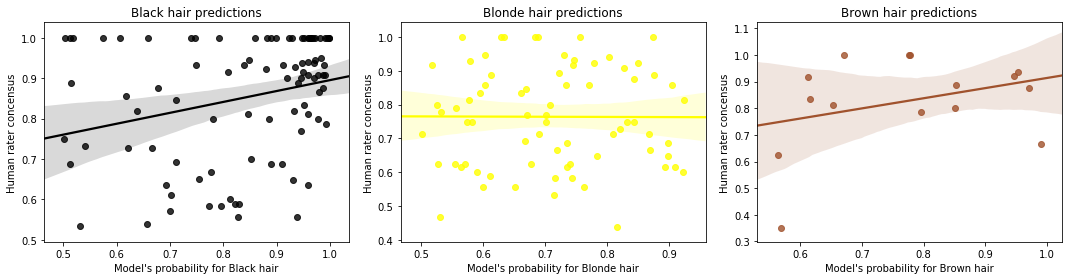

In [28]:
pred_black = hairnotie[hairnotie.prediction == 'black']
pred_blonde = hairnotie[hairnotie.prediction == 'blonde']
pred_brown = hairnotie[hairnotie.prediction == 'brown']

f, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(15, 4))

sns.regplot(x="black", y="hair_consensus_prop", data=pred_black, ax=ax1,  color = 'black').set(ylabel='Human rater concensus', xlabel="Model's probability for Black hair",  title='Black hair predictions')
sns.regplot(x="blond", y="hair_consensus_prop", data=pred_blonde, ax=ax2,  color = 'yellow').set(ylabel='Human rater concensus', xlabel="Model's probability for Blonde hair",  title='Blonde hair predictions')
sns.regplot(x="brown", y="hair_consensus_prop", data=pred_brown, ax=ax3,  color = 'sienna').set(ylabel='Human rater concensus', xlabel="Model's probability for Brown hair",  title='Brown hair predictions')

plt.tight_layout()

In [30]:
blackhair = hairnotie[hairnotie.hair_perceived == 'black']

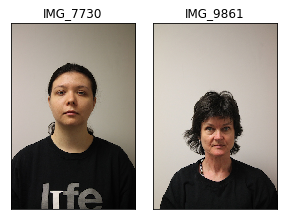

In [33]:
black_blonde = blackhair[blackhair.prediction == 'blonde']

plt.figure(figsize=(8,5))

for i, face in enumerate(black_blonde.faceID.values):
    
    plt.subplot(1,4,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel('prediction: ' + not_asian_wrong.prediction.values[i] + ' ' + str(round(not_asian_wrong.asian.values[i], 2)) )

plt.tight_layout()

plt.show()

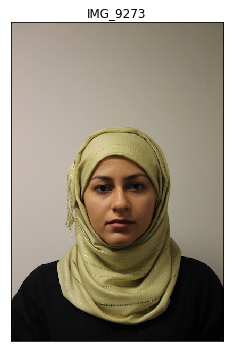

In [35]:
black_brown = blackhair[blackhair.prediction == 'brown']

plt.figure(figsize=(8,5))

for i, face in enumerate(black_brown.faceID.values):
    
    plt.subplot(1,1,i+1).set_title(face)
    
    face = face + ".JPG"
    img=mpimg.imread(img_dir + face)
    imgplot = plt.imshow(img)
    
    #remove ticks for x and y axes
    plt.xticks([], [])
    plt.yticks([], [])
    
    #label probability male score
    #plt.xlabel('prediction: ' + not_asian_wrong.prediction.values[i] + ' ' + str(round(not_asian_wrong.asian.values[i], 2)) )

plt.tight_layout()

plt.show()